In [1]:
import string, re
import numpy as np 
import pandas as pd 

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [2]:
new_df = pd.read_csv("clean_dataset/clean_dataset_4973.csv")
new_df.drop(["Unnamed: 0"], axis=1, inplace=True)
new_df.head()

,Tweets,label
0,"To the law enforcement agencies, doctors, para...",political
1,"Rather, just for the support and pleasure of t...",political
2,І не забуваймо багатостраждальний український ...,religious
3,Balloki Nature Reserve initiated in 2019 by ta...,political
4,I extend my profound condolences on the sad de...,political


In [3]:
# define text preprocessing functions
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    words_filtered = [word for word in words if not word.lower() in stop_words]
    return ' '.join(words_filtered)

def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_numbers(text):
    return re.sub(r'\d+', '', text)

def stem_words(text):
    stemmer = PorterStemmer()
    words = word_tokenize(text)
    words_stemmed = [stemmer.stem(word) for word in words]
    return ' '.join(words_stemmed)

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    words_lemmatized = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words_lemmatized)

In [4]:
new_df['Tweets'] = new_df['Tweets'].apply(lambda x: str(x).lower())  # convert to lowercase
new_df['Tweets'] = new_df['Tweets'].apply(remove_stopwords)     # remove stopwords
new_df['Tweets'] = new_df['Tweets'].apply(remove_punctuation)   # remove punctuation
new_df['Tweets'] = new_df['Tweets'].apply(remove_numbers)       # remove numbers
new_df['Tweets'] = new_df['Tweets'].apply(stem_words)           # stem words
new_df['Tweets'] = new_df['Tweets'].apply(lemmatize_words)      # lemmatize words
new_df.head()

,Tweets,label
0,law enforc agenc doctor paramed staff border g...,political
1,rather support pleasur indian lobbi will readi...,political
2,і не забуваймо багатостраждальний український ...,religious
3,balloki natur reserv initi take land back land...,political
4,extend profound condol sad demis former presid...,political


In [5]:
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd

In [6]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(new_df['Tweets'], new_df['label'], test_size=0.2)

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, max_depth=5)
rf.fit(X_train_tfidf, y_train)
joblib.dump(rf, 'trained_model/rf_model.joblib')

['rf_model.joblib']

In [7]:
loaded_model = joblib.load('trained_model/rf_model.joblib')
y_pred = loaded_model.predict(X_test_tfidf)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.8914572864321608


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Generate classification report and confusion matrix
print('Classification Report:\n', classification_report(y_test, y_pred))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

   political       0.86      0.95      0.90       520
   religious       0.94      0.83      0.88       475

    accuracy                           0.89       995
   macro avg       0.90      0.89      0.89       995
weighted avg       0.90      0.89      0.89       995

Confusion Matrix:
 [[495  25]
 [ 83 392]]


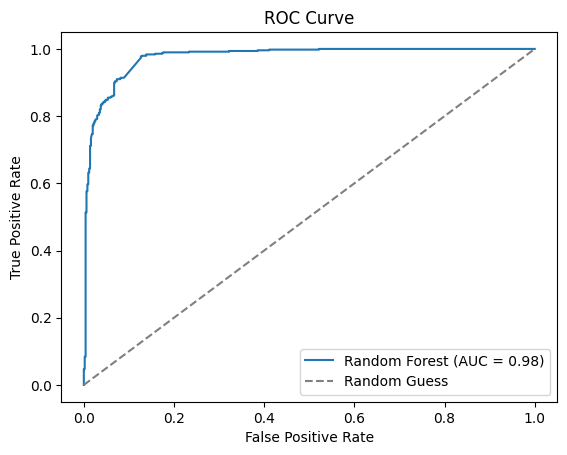

In [19]:
le = LabelEncoder()
y_test_binary = le.fit_transform(y_test)

# Generate AUC curve
y_pred_proba = loaded_model.predict_proba(X_test_tfidf)[:,1]
auc = roc_auc_score(y_test_binary, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()